In [1]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
%matplotlib inline

Based on https://medium.com/@awjuliani/simple-reinforcement-learning-with-tensorflow-part-4-deep-q-networks-and-beyond-8438a3e2b8df#.rvpnvy5gz

In [2]:
env = gym.make("Asterix-v0")

[2017-02-03 01:13:18,704] Making new env: Asterix-v0


In [63]:
class Qnetwork():
    def __init__(self, input_size, actions_size):
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        self.scalarInput =  tf.placeholder(shape=[None,input_size[0] * input_size[1] * input_size[2]],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,input_size[0],input_size[1],input_size[2]])
        self.conv1 = tf.contrib.layers.convolution2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        self.conv2 = tf.contrib.layers.convolution2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv3 = tf.contrib.layers.convolution2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
        self.conv4 = tf.contrib.layers.convolution2d( \
            inputs=self.conv3,num_outputs=512,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
        conv4_shape = self.conv4.get_shape().as_list()
        #We take the output from the final convolutional layer and split it into separate advantage and value streams.
        self.streamAC, self.streamVC = tf.split(3,2,self.conv4)
        self.streamA = tf.contrib.layers.flatten(self.streamAC)
        self.streamV = tf.contrib.layers.flatten(self.streamVC)
        self.AW = tf.Variable(tf.random_normal([conv4_shape[1]*conv4_shape[2]*conv4_shape[3]//2, actions_size]))
        self.VW = tf.Variable(tf.random_normal([conv4_shape[1]*conv4_shape[2]*conv4_shape[3]//2, 1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Then combine them together to get our final Q-values.
        self.Qout = self.Value + tf.sub(self.Advantage,tf.reduce_mean(self.Advantage,reduction_indices=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout, 1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions, actions_size,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.mul(self.Qout, self.actions_onehot), reduction_indices=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

In [5]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self, experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self, size):
        return np.reshape(np.array(random.sample(self.buffer, size)), [size, 5])

In [6]:
def processState(states, input_size):
    return np.reshape(states,[input_size[0] * input_size[1] * input_size[2]])

In [7]:
def updateTargetGraph(tfVars, tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

In [8]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
anneling_steps = 10000. #How many steps of training to reduce startE to endE.
num_episodes = 10000 #How many episodes of game environment to train network with.
pre_train_steps = 10000 #How many steps of random actions before training begins.
max_epLength = 50 #The max allowed length of our episode.
load_model = False #Whether to load a saved model.
path = "./dqn" #The path to save our model to.
tau = 0.001 #Rate to update target network toward primary network

In [9]:
input_size = env.observation_space.shape
actions_size = env.action_space.n

In [70]:
tf.reset_default_graph()
mainQN = Qnetwork(input_size, actions_size)
targetQN = Qnetwork(input_size, actions_size)

init = tf.initialize_all_variables()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/anneling_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)

    sess.run(init)
    updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        s = env.reset()
        s = processState(s, input_size)
        d = False
        rAll = 0
        j = 0
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0, actions_size)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            s1,r,d,_ = env.step(a)
            s1 = processState(s1, input_size)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
            rAll += r
            s = s1
            
            if d == True:

                break
        
        #Get all experiences from this episode and discount their rewards.
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.cptk')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.cptk')

Instructions for updating:
Use `tf.global_variables_initializer` instead.


[2017-02-03 01:36:50,215] From <ipython-input-70-eee0c5ea0656>:5 in <module>.: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


Saved Model
500 120.0 1
1000 115.0 1
1500 115.0 1
2000 130.0 1
2500 130.0 1
3000 95.0 1
3500 135.0 1
4000 120.0 1
4500 125.0 1
5000 105.0 1
5500 125.0 1
6000 130.0 1
6500 115.0 1
7000 130.0 1
7500 120.0 1
8000 120.0 1
8500 110.0 1
9000 105.0 1
9500 100.0 1
10000 105.0 1
10500 125.0 0.9549999999999828
11000 145.0 0.9099999999999655
11500 110.0 0.8649999999999483
12000 100.0 0.819999999999931
12500 110.0 0.7749999999999138
13000 110.0 0.7299999999998965
13500 115.0 0.6849999999998793
14000 100.0 0.639999999999862
14500 150.0 0.5949999999998448
15000 120.0 0.5499999999998275
15500 95.0 0.5049999999998103
16000 125.0 0.4599999999998177
16500 140.0 0.41499999999982823
17000 115.0 0.36999999999983874
17500 115.0 0.32499999999984924
18000 110.0 0.27999999999985975
18500 150.0 0.23499999999986562
19000 95.0 0.18999999999986225
19500 110.0 0.14499999999985888
20000 115.0 0.09999999999985551
20500 105.0 0.09999999999985551
21000 130.0 0.09999999999985551
21500 150.0 0.09999999999985551
22000 115

KeyboardInterrupt: 

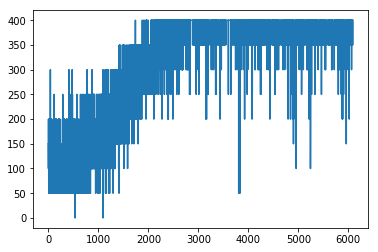

In [75]:
plt.plot(rList)